In [29]:
##
#Load Packages
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import sys
from scipy.optimize import curve_fit

In [30]:
##
#Define Path to Code database
DirPath = '/Your/Path/To/Code/'

In [31]:
##
#Load functions
sys.path.append(''.join([DirPath,'bin']))
from EPGMotion import *
from MotionSimulation import *
from EPGForwardMotionModel import *
from Jacobian_MotionCorrection import *
from ParameterOptionsSimulation import *

In [32]:
##
#Read Parameters
opt=ParameterOptionsSimulation()

In [33]:
##
#Conventional EPG simulates a maximum k-value pathway equal to the number of TRs. This piece of code identifies where increasing the k-value leads to no meaningful change in the signal, with subsequent thresholding to accelerate modelling
opt["kOrder"] = kOrder(opt.copy())

In [34]:
##
#Define Motion Operators - Translation Velocity (mm/s), Rotation Velocity (deg/s), and Maximum Cardiac Velocity (mm/s) along x,y & z-axes
Trans= np.array([0, 0, 0])
Rot = np.array([0, 0, 0])
Card = np.array([0, 0, 0.4])

##
#Define Voxel Dimensions 
VoxDims = np.array([1,1,1])

In [35]:
##
#Estimate T(t) operator
T = np.squeeze(MotionOperator(opt.copy(),Trans,Rot,Card,opt['Mask'][:,np.newaxis,np.newaxis],VoxDims))[:,np.newaxis]

In [36]:
##
#Estimate Signal
Signal=EPGMotion(opt, np.squeeze(T))

In [37]:
##
#Add Noise

##
#Define SNR Level
SNR = [20]

##
#Estimate Noise Standard Deviation
NoiseSD = np.mean(abs(Signal[int(opt["nDummy"]):]))/SNR

##
#Initialise SignalNoise repeats
SignalNoise = np.zeros_like(Signal)

##
#Add Noise
SignalNoise = (np.real(Signal) + np.random.normal(0, NoiseSD, Signal.shape[0])) + 1j*(np.imag(Signal) + np.random.normal(0, NoiseSD, Signal.shape[0]))

In [38]:
##
#Define lower and upper parameter bounds (fix S0 equal to 1, define MotionParameters between -5 and 5 mm/s))
low = [1E-6, 1, -20*np.pi, *np.ones((int(opt["nTR"])-int(opt["SteadyStateTR"])))*-5]
high = [10E-3, 1+ + np.finfo('f8').eps, 20*np.pi, *np.ones((int(opt["nTR"])-int(opt["SteadyStateTR"])))*5]

In [39]:
##
#Fitting without Motion Information

##
#Initialise fitting parameters (D, S0, Phi)
par_init = [0.5E-4, 1, np.pi/2]

##
#Initialise Array
poptnoMotion = np.zeros((3,*SignalNoise.shape[1:]))

##
#Define Input Data (1D array: Real & Imaginary Components - Fitting to After Dummy Region)
Data = np.concatenate((np.real(SignalNoise[int(opt["nDummy"]):]).reshape(SignalNoise[int(opt["nDummy"]):].shape[0]),np.imag(SignalNoise[int(opt["nDummy"]):]).reshape(SignalNoise[int(opt["nDummy"]):].shape[0])))

##
#Perform Fitting
poptnoMotion, pcov, infodict, mesg, ier  = curve_fit(lambda x, *theta: EPGForwardModelFitting(x, theta, opt.copy()), 1, Data, p0=par_init, method='trf',absolute_sigma=False,bounds=(low[0:3],high[0:3]),verbose=1,jac=lambda x, *theta: EPGForwardModelFittingJacobian(x,theta,opt.copy()), x_scale='jac',full_output=True,tr_solver='exact',max_nfev=1E5,ftol=1e-3, xtol=1e-3, gtol=1e-3)


`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 1.6897e-01, final cost 5.6156e-03, first-order optimality 4.72e-05.


/Users/btendler/miniconda3/envs/MotionCorrection_DWSSFP/lib/python3.8/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/Users/btendler/miniconda3/envs/MotionCorrection_DWSSFP/lib/python3.8/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new


In [40]:
##
#Fitting with Motion Information

##
#Initialise fitting parameters (D, S0, Phi, MotionVector)
par_init = [0.5E-4, 1, np.pi/2, *np.zeros(int(opt["nTR"])-int(opt["SteadyStateTR"]))]

##
#Initialise Array
poptMotion = np.zeros((len(low),*SignalNoise.shape[1:]))

##
#Define Input Data (1D array: Real & Imaginary Components - Fitting to After Dummy Region)
Data = np.concatenate((np.real(SignalNoise[int(opt["nDummy"]):]).reshape(SignalNoise[int(opt["nDummy"]):].shape[0]),np.imag(SignalNoise[int(opt["nDummy"]):]).reshape(SignalNoise[int(opt["nDummy"]):].shape[0])))

##
#Perform Fitting
poptMotion, pcov, infodict, mesg, ier  = curve_fit(lambda x, *theta: EPGForwardMotionModelFitting(x, theta, opt.copy()), 1, Data, p0=par_init, method='trf',absolute_sigma=False,bounds=(low,high),verbose=1,jac=lambda x, *theta: EPGForwardMotionModelFittingJacobian(x,theta,opt.copy()), x_scale='jac',full_output=True,tr_solver='exact',max_nfev=1E5,ftol=1e-3, xtol=1e-3, gtol=1e-3)

/Users/btendler/miniconda3/envs/MotionCorrection_DWSSFP/lib/python3.8/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar multiply
  alpha *= Delta / Delta_new
/Users/btendler/miniconda3/envs/MotionCorrection_DWSSFP/lib/python3.8/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)


`xtol` termination condition is satisfied.
Function evaluations 507, initial cost 1.6897e-01, final cost 6.4864e-05, first-order optimality 3.64e-03.


In [42]:
##
#Reconstruct Signal & Motion Profile

#Create Reconstructed Motion Array
TRecon = np.zeros_like(SignalNoise, dtype = 'f8')
TRecon[-(int(opt["nTR"])-int(opt["SteadyStateTR"])):] = poptMotion[3:]

#Initialise Signal Array
SignalRecon = np.zeros_like(SignalNoise, dtype = 'c8')

##
#Define Parameters
optRecon = opt.copy()
optRecon['D'] = np.asarray([poptMotion[0]], dtype='f8')   
optRecon['phi'] = np.asarray([poptMotion[2]], dtype='f8') 

##
#Reconstruct signal
SignalRecon = EPGMotion(optRecon.copy(), TRecon)


In [55]:
##
#Print statement on diffusion coefficients
print(''.join(['Simulated diffusion coefficient D = ',str(opt['D'][0]*10**3), r' x $10^{3}$ mm^2/s']))
print(''.join(['Without Motion correction, estimated diffusion coefficient D = ',str(poptnoMotion[0]*10**3),r' x $10^3 mm^2/s$']))
print(''.join(['With Motion correction, estimated diffusion coefficient D = ',str(poptMotion[0]*10**3),r' x $10^3 mm^2/s$']))

Simulated diffusion coefficient D = 1.0 x $10^{3}$ mm^2/s
Without Motion correction, estimated diffusion coefficient D = 1.9795001499868232 x $10^3 mm^2/s$
With Motion correction, estimated diffusion coefficient D = 1.0687296690745014 x $10^3 mm^2/s$


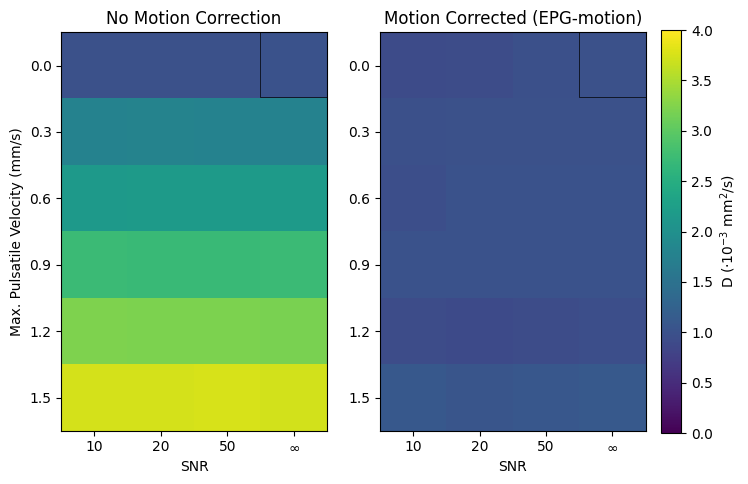

In [170]:
##
#Plot 
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(8,12)
#Define x-axis
Time = range(Signal.shape[0])*opt["TR"]/1E3
#Plot Magnitude data
axs[0].plot(Time, np.abs(SignalNoise),'#1f77b4',linewidth=2,label = 'Data (Monte Carlo)')
axs[0].plot(Time,np.abs(SignalRecon),'#ff7f0e',linewidth=2,linestyle='--',label = 'Fit (EPG + Motion)' )
axs[0].axvspan(Time[int(opt["SteadyStateTR"])],Time[int(opt["nDummy"])], alpha=0.1,color='#d62728',label = 'Dummy Measurements')
axs[0].axvspan(Time[int(opt["nDummy"])],Time[-1],alpha=0.1,color='#2ca02c',label = 'Measured Data')
#Plot Phase data (multiply by -i to characterise the motion-free phase as 0)
axs[1].plot(Time, np.angle(SignalNoise*-1),'#1f77b4',linewidth=2)
axs[1].plot(Time,np.angle(SignalRecon*-1),'#ff7f0e',linewidth=2,linestyle='--')
axs[1].axvspan(Time[int(opt["SteadyStateTR"])],Time[int(opt["nDummy"])], alpha=0.1,color='#d62728')
axs[1].axvspan(Time[int(opt["nDummy"])],Time[-1],alpha=0.1,color='#2ca02c')
#Plot Time-Series Data
axs[2].plot(Time,T,'#1f77b4',linewidth=2)
axs[2].plot(Time,TRecon,'#ff7f0e',linewidth=2,linestyle='--')
axs[2].axvspan(Time[int(opt["SteadyStateTR"])],Time[int(opt["nDummy"])], alpha=0.1,color='#d62728')
axs[2].axvspan(Time[int(opt["nDummy"])],Time[-1],alpha=0.1,color='#2ca02c')
#Add labels etc
fig.subplots_adjust(hspace=0.4)
axs[0].text(-0.1, 1.05, '(a)', transform=axs[0].transAxes, size=20)
axs[2].text(-0.1, 1.05, '(b)', transform=axs[2].transAxes, size=20)
axs[0].set_xlim([0,Time[-1]])
axs[1].set_xlim([0,Time[-1]])
axs[2].set_xlim([0,Time[-1]])
axs[1].set_ylim([-np.pi,np.pi])
axs[0].set_ylabel('Amplitude (a.u.)',fontsize=12)
axs[1].set_ylabel('Angle (rad.)',fontsize=12)
axs[2].set_ylabel('Velocity (mm/s)',fontsize=12)
axs[0].set_xlabel('Time (s)',fontsize=12)
axs[1].set_xlabel('Time (s)',fontsize=12)
axs[2].set_xlabel('Time (s)',fontsize=12)
axs[0].set_title('Magnitude',fontsize=16)
axs[1].set_title('Phase',fontsize=16)
axs[2].set_title(r'$T(t)$',fontsize=16)
axs[1].set_yticks([-np.pi,0, np.pi],[r'-$\pi$',0, r'$\pi$'])
axs[0].legend(fontsize=10)